## Import Libraries for Math, Distributions, Plotting

This notebook is the same as the other one, but with naive parallelization built in to batch out the trials.

In [1]:
import ipyparallel as ipp # import the client
rc = ipp.Client()
dv = rc[:]
rc.ids # list the ids of the engine the client can communicate with

/home/mpilosov/anaconda3/envs/test_py_env/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@math-ws-204')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


[0, 1, 2, 3]

In [2]:
%%px
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from scipy.stats import uniform
# from scipy.stats import chi2
from scipy.stats import gaussian_kde as gkde
from scipy.stats import multivariate_normal
# import scipy.stats as sstats 
from ipywidgets import *

In [11]:
%%px
def make_model(skew):
    # this function makes a linear map whos first component is the x-unit vector
    # and each subsequent component is a norm-1 vector satisfying the property
    # that the 2-2 map made from it and the aforementioned unit vector is a map
    # with skewness in skew_range, which is a list of desired skewnesses   
    # TODO currently this map only works for 2-D input space     
    
    def my_model(parameter_samples):
        Q_map = [ [1.0, 0.0] ] # all map components have the same norm, rect_size to have measures of events equal btwn spaces.
        Q_map.append( [np.sqrt(np.array(skew)**2 - 1), 1] ) # taken with the first component, this leads to a 2-2 map with skewsness 's'
        Q_map = np.array( Q_map )
        QoI_samples = np.dot(parameter_samples, np.transpose(Q_map))
        return QoI_samples
    return my_model

## Set Simulation Options

We are trying to determine the relationship between skewness and the number of samples required to approximate a solution to the inverse problem according to the $L^1$ metric (Total Variation).  

In [12]:
%%px
lambda_ref = np.array([0.5, 0.5])
# num_samples = np.array([1E2, 1E3, 1E4, 1E5]).astype('int') # independent variable
# num_samples = np.array([1E2, 2E2, 3E2, 4E2, 5E2]).astype('int')
num_samples = np.array([250, 500, 1000, 2000, 4000, 8000, 16000]).astype('int') # independent variable


# Number of Samples used for reference solution, number of trials
num_emulate = int(1E6)

# define some handles for functions we will use.
# prior_dist = np.random.uniform
prior_dist = uniform # can use any scipy.stats class
obs_density = 'uniform' # choose 'uniform' or 'normal'. will error otherwise / use what is in memory


In [13]:
%%px
skew_range = np.array([1, 2, 4]) # skewnesses you want to compare
sigma = 1E-3 # for the normal observed distribution choice
scale = 0.2 # for the uniform

## Define Global Variables for Parallel Run

In [14]:
# all this needs to be defined outside of the parallel environment.
import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
num_trials = 5
trial_seed_list = list(range(num_trials))
dv.scatter('trial_chunk', trial_seed_list)

<AsyncResult: scatter>

## Run Experiment (in Parallel)

The following linear map $Q_s: \mathbb{R}^2 \to \mathbb{R}^2$ is defined to have skewness $s$ at all $\lambda \in \Lambda$.  

$$
Q_s(\lambda) = \lbrace \, \lambda_1, \; \lambda_1 \sqrt{s^2 - 1} + \lambda_2 \, \rbrace
$$

Since we are parallelizing the trials across the processors, we should define certain variables so that each processor has the same references.

In [15]:
%%px
# pass the same emulated samples to everything.
lam_emulate = prior_dist.rvs( size=(num_emulate, 2) )

def run_trial(trial_seed):
    ell_1_error = np.zeros( (skew_range.size, num_samples.size) )
    hd_error = np.zeros( (skew_range.size, num_samples.size) )
    for s_idx, s in enumerate(skew_range):
    #     print('Skewness = ', s) 
        Q = make_model([s])
        q_emulate = Q( lam_emulate )
        pf_dens_ref = gkde(q_emulate.transpose()) # reference pushforward density

        q_center = Q(lambda_ref)
        if obs_density == 'normal':
            obs = multivariate_normal(mean=q_center, cov=sigma) # define the handle, can now call .pdf
        elif obs_density == 'uniform':
            obs = uniform(loc=q_center-0.5*scale, scale=scale)
        
        # map ahead of time in order to save on repeated computations
        np.random.seed(trial_seed) # this ensures that as N grows, we "reuse" the prior evaluations.
        lam_full = prior_dist.rvs( size=(np.max(num_samples), 2) )
        q_full = Q(lam_full)
        
        for N_idx, N in enumerate(num_samples):
#             print( '(skew, N, k) = (%d, %d, %d)'%(s, N, trial_seed) )
            lam = lam_full[:N,:] # generate some coarse approximations 
            q = q_full[:N,:]
            pf_dens_approx = gkde(q.transpose())
            if obs_density == 'normal':
                ell_1_error[s_idx, N_idx] = ( 1.0/N * np.sum( np.abs(
                    obs.pdf(q)*(  1/pf_dens_ref.pdf(q.transpose()) - 1./pf_dens_approx.pdf(q.transpose())  ) )) )
            elif obs_density == 'uniform':
#                 ell_1_error[s_idx, N_idx] = ( 1.0/N * np.sum( np.abs(
#                     np.prod(obs.pdf(q), axis=1)*(  1./pf_dens_ref.pdf(q.transpose()) - 1./pf_dens_approx.pdf(q.transpose())  ) )) )
                hd_error[s_idx, N_idx] = 0.5/N * np.linalg.norm(
                    np.sqrt(np.prod(obs.pdf(q), axis=1))*( 1./np.sqrt(pf_dens_ref.pdf(q.transpose())) - 1./np.sqrt(pf_dens_approx.pdf(q.transpose()))  ) )
    print("Done.")
#     return ell_1_error
    return hd_error

In [16]:
%%capture output
%%px
L1_error = list(map(run_trial, trial_chunk))

In [20]:
output.show()

[stdout:0] 
Done.
Done.
[stdout:1] Done.
[stdout:2] Done.
[stdout:3] Done.


In [18]:
ell_1_error = np.array(list(dv.gather('L1_error').get() ))
np.save("savefile_uni_hd.npy", ell_1_error)

In [19]:
mean_ell_1_error = np.mean(ell_1_error, axis=0) # average out the five trials
mean_ell_1_error

array([[2.20614813e-03, 8.89466427e-04, 6.14442514e-04, 5.17231342e-04,
        2.94182330e-04, 1.40921115e-04, 9.05795993e-05],
       [2.33389707e-03, 1.06956336e-03, 7.17780176e-04, 5.54348843e-04,
        2.82344062e-04, 1.33302493e-04, 8.28616472e-05],
       [2.57135057e-03, 1.18483368e-03, 8.69030991e-04, 5.63525031e-04,
        3.02591774e-04, 1.55862488e-04, 9.89755391e-05]])

### Plotting Code
** MANUALLY make sure that `num_samples` is correct **


    (TODO: Figure out how to grab them from one of the parallel threads instead.)

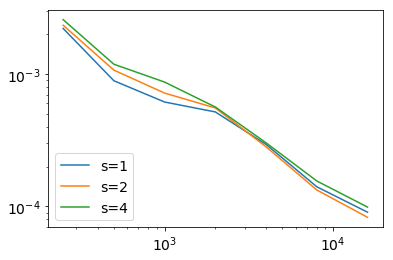

In [21]:
# num_samples = np.array([1E2, 1E3, 1E4, 1E5]).astype('int') # independent variable
num_samples = np.array([250, 500, 1000, 2000, 4000, 8000, 16000]).astype('int') # independent variable

skew_range = [1,2,4]

for s_idx, s in enumerate(skew_range):
    plt.loglog(num_samples, mean_ell_1_error[s_idx,:], label='s=%d'%s)
plt.legend(loc=3)

plt.savefig('convergence_linearQ_param_skew_vs_samples_uniform_full_hd.pdf')

In [ ]:
print( mean_ell_1_error[0,:]/mean_ell_1_error[2,:] ) # convergence rate